In [ ]:
# Pegar os dados no Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importações, carregamento e rotulação dos dados

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from tqdm.notebook import tqdm # Barras de Progresso

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
sns.set_theme() # Define o estilo dos gráficos para o tema padrão

In [ ]:
X_train = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/normal_network.csv")

In [ ]:
df_fuzzy = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/fuzzy_attack.csv")
df_spoofing = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/spoofing_attack.csv")
df_replay = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/replay_attack.csv")
df_ddos = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/DDoS_attack.csv")

In [ ]:
# Rotular os dados ## 0 - BENIGN | 1 - MALICIOUS

dfs = [df_fuzzy, df_spoofing, df_replay, df_ddos]
for df in dfs:
  df['Label'] = df['B1'].apply(lambda x: 1.0 if x == 1 else 0.0)

## Replay e DDoS - B1 fica com o valor 0
df_ddos['B1'] = 0
df_replay['B1'] = 0

## Spoofing e Fuzzy - Preciso preencher B1 com um valor de byte
mask = df_fuzzy['B1'] == 1
random_hex_values = [np.random.randint(256) for _ in range(mask.sum())]
df_fuzzy.loc[mask, 'B1'] = random_hex_values

mask = df_spoofing['B1'] == 1
random_hex_values = [np.random.randint(256) for _ in range(mask.sum())]
df_spoofing.loc[mask, 'B1'] = random_hex_values


### Tratamento das bases de dados

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713011 entries, 0 to 2713010
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration ID  int64  
 2   Extended ID     bool   
 3   RTR             bool   
 4   DLC             int64  
 5   B1              float64
 6   B2              float64
 7   B3              float64
 8   B4              float64
 9   B5              float64
 10  B6              float64
 11  B7              float64
 12  B8              float64
dtypes: bool(2), float64(9), int64(2)
memory usage: 232.9 MB


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = X_train.shape[0]
X_train = X_train.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {X_train.shape[0]} | Descartados {initial_len - X_train.shape[0]} registros com valores NA')

Tamanho inicial: 2713011, tamanho final 2713010 | Descartados 1 registros com valores NA


In [ ]:
# Tratando os valores do timestamp

dfs = [df_fuzzy, df_spoofing, df_replay, df_ddos, X_train]
for df in dfs:
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
  df['Timestamp'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()

In [ ]:
# Passar os valores em hexadecimal para decimal

dfs = [df_fuzzy, df_spoofing, df_replay, df_ddos]
for df in dfs:
  df['Arbitration ID'] = df['Arbitration ID'].apply(lambda x: int(x, 16))

In [ ]:
# Trocando o valor de False para 0.0

X_train['RTR'] = 0.0
X_train['Extended ID'] = 0.0

In [ ]:
# Passar os valores inteiros para o tipo float

dfs = [df_fuzzy, df_spoofing, df_replay, df_ddos, X_train]
columns = ['Arbitration ID', 'DLC', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

for df in dfs:
  for column in columns:
    df[column] = df[column].apply(lambda x: float(x))

In [ ]:
X_train

,Timestamp,Arbitration ID,Extended ID,RTR,DLC,B1,B2,B3,B4,B5,B6,B7,B8
0,0.000000,12.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,212.0,79.0,0.0,0.0
1,0.000217,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000469,10.0,0.0,0.0,8.0,0.0,0.0,0.0,128.0,8.0,0.0,0.0,0.0
3,0.003145,15.0,0.0,0.0,8.0,0.0,0.0,0.0,128.0,101.0,0.0,0.0,0.0
4,0.006306,10.0,0.0,0.0,8.0,0.0,0.0,0.0,128.0,8.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713006,5333.664120,10.0,0.0,0.0,8.0,0.0,0.0,0.0,128.0,24.0,0.0,0.0,0.0
2713007,5333.666213,12.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,208.0,43.0,0.0,0.0
2713008,5333.666346,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2713009,5333.666880,15.0,0.0,0.0,8.0,0.0,0.0,0.0,128.0,101.0,0.0,0.0,0.0


## Divisão dos dados

In [ ]:
# Separando os dados em teste e validação sequencialmente

val_size_fuzzy = int(len(df_fuzzy) * .65)
val_size_spoofing = int(len(df_spoofing) * .65)
val_size_replay = int(len(df_replay) * .65)
val_size_ddos = int(len(df_ddos) * .65)

X_val_fuzzy, X_test_fuzzy = df_fuzzy[:val_size_fuzzy].reset_index(drop=True), df_fuzzy[val_size_fuzzy:].reset_index(drop=True)
Y_val_fuzzy, Y_test_fuzzy = X_val_fuzzy['Label'], X_test_fuzzy['Label']
X_val_fuzzy.drop(columns=['Label'], inplace=True)
X_test_fuzzy.drop(columns=['Label'], inplace=True)

X_val_spoofing, X_test_spoofing = df_spoofing[:val_size_spoofing].reset_index(drop=True), df_spoofing[val_size_spoofing:].reset_index(drop=True)
Y_val_spoofing, Y_test_spoofing = X_val_spoofing['Label'], X_test_spoofing['Label']
X_val_spoofing.drop(columns=['Label'], inplace=True)
X_test_spoofing.drop(columns=['Label'], inplace=True)

X_val_replay, X_test_replay = df_replay[:val_size_replay].reset_index(drop=True), df_replay[val_size_replay:].reset_index(drop=True)
Y_val_replay, Y_test_replay = X_val_replay['Label'], X_test_replay['Label']
X_val_replay.drop(columns=['Label'], inplace=True)
X_test_replay.drop(columns=['Label'], inplace=True)

X_val_ddos, X_test_ddos = df_ddos[:val_size_ddos].reset_index(drop=True), df_ddos[val_size_ddos:].reset_index(drop=True)
Y_val_ddos, Y_test_ddos = X_val_ddos['Label'], X_test_ddos['Label']
X_val_ddos.drop(columns=['Label'], inplace=True)
X_test_ddos.drop(columns=['Label'], inplace=True)



## Normalização dos dados

In [ ]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_val_fuzzy, norm_X_test_fuzzy = std_scaler.transform(X_val_fuzzy), std_scaler.transform(X_test_fuzzy)
norm_X_val_spoofing, norm_X_test_spoofing = std_scaler.transform(X_val_spoofing), std_scaler.transform(X_test_spoofing)
norm_X_val_replay, norm_X_test_replay = std_scaler.transform(X_val_replay), std_scaler.transform(X_test_replay)
norm_X_val_ddos, norm_X_test_ddos = std_scaler.transform(X_val_ddos), std_scaler.transform(X_test_ddos)

In [ ]:
del X_train
del X_val_fuzzy, X_test_fuzzy
del X_val_spoofing, X_test_spoofing
del X_val_replay, X_test_replay
del X_val_ddos, X_test_ddos

## Detecção de anomalias com Kmeans

In [ ]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

### Descobrindo o melhor valor de K

In [ ]:
# Criamos um subconjunto com 2% dos dados de treinamento

subset_train_size = int(norm_X_train.shape[0]*0.02)
train_indexes = [i for i in range(subset_train_size)]
norm_X_train_subset = norm_X_train[train_indexes,:]


In [ ]:
# Analisamos a pontuação obtida na métrica silhouette score para os clusters formados para diferentes valores de K

k_list = list(range(2, 21))
silhouette_score_list = []

for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=30)
    model_kmeans = model_kmeans.fit(norm_X_train_subset)

    s_score = silhouette_score(norm_X_train_subset, model_kmeans.predict(norm_X_train_subset))
    silhouette_score_list.append(s_score)

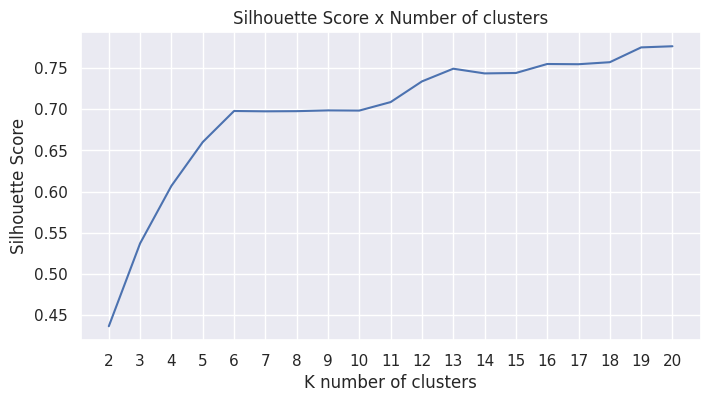

In [ ]:
### Não é preciso entender de verdade, é só para plotar o gráfico

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

### Treinamento do Kmeans que usaremos

In [ ]:
# Definição e treinamento do modelo Kmeans

K_CLUSTERS = 20
model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init=30)
model_kmeans = model_kmeans.fit(norm_X_train)

In [ ]:
from pickle import dump
with open("filename.pkl", "wb") as f:
    dump(model_kmeans, f, protocol=5)


In [ ]:
import joblib
joblib.dump(std_scaler, 'scalerKMeans.pkl')

['scalerKMeans.pkl']

### Análise PCA

In [ ]:
# Análise PCA

def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED) # Reduziremos a dimensionalidade dos dados para 2
  X_pca = pca.fit_transform(X)


  fig, ax = plt.subplots(figsize=(8, 4))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]
    X_clusters = model_kmeans.predict(X)

    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

<ipython-input-17-96a2e3218ae7>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


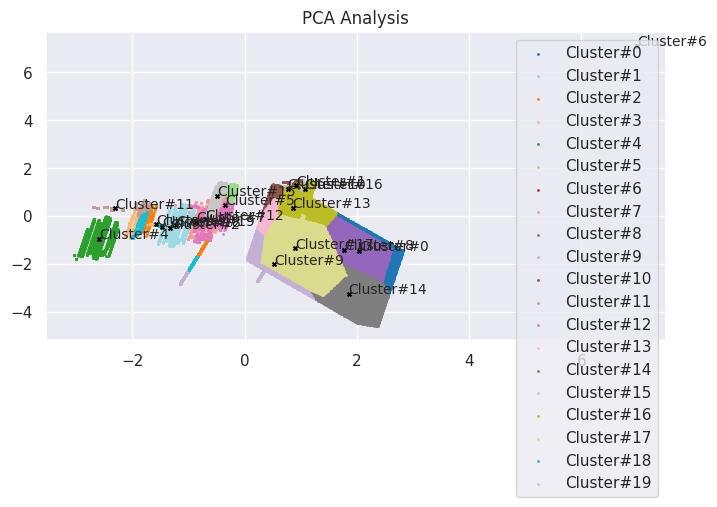

In [ ]:
plot_pca(norm_X_train, model_kmeans, print_centroids=True)